# Word2vec and Glove

 In this notebook I use already pre-trained word-embedding models like Word2vec and Glove. These models were trained on huge datasets to get semantic meaning of each word. Word2vec relies on backpropagation, while Glove on matrix factorization. Both models can capture meaning of words pretty well compared to bag of words or tf-idf.

 I try these methods:
 1. Building article embeddings based on averaging word2vec embeddings
     1. based on already pretrained word2vec + training it on our dataset
     2. based on already pretrained word2vec

 2. Building article embeddings based on the combination of word2vec and tfidf 
 3. Building article embeddings based on averaging glove embeddings


In [41]:
# data preprocessing, visualization
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import nltk

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# models
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
from sklearn.ensemble import RandomForestClassifier
from gensim.models import Word2Vec
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

In [42]:
# df_merged = pd.read_csv("../data/merged_all_datasets.csv")
# df_merged = pd.read_csv("../data/merged_datasetes_balanced.csv")
df_merged = pd.read_csv("../data/merged_datasetes_balanced_huge.csv")

In [43]:
x_train, x_test, y_train, y_test = train_test_split(
    df_merged["title"], 
    df_merged["clickbait"],
    test_size=0.2, 
    random_state=42
)

# Word2Vec, some history and exploring the model

In [44]:
# Thomas Mikolov tried to find the meaning of words and how to represent them numerically
# He came up with an idea to train neural network so that words that appear in similar contexts have close vectors
# Word vectors provide semantic meaning of words as vectors based on training corpus
# This algorithm was a great invention that allows to capture analogies 
# (e.g.  king - man + woman = queen or woman + europe + physics + scientist = Marie Curie

# source: Natural Language Processing in Action (book)

In [45]:
# I train Word2Vec on my own data, but the thing is that the articles are general and our corpus is not so huge
# We could use all merged datasets instead of balanced, but still the domain of my data is general
# Hence it would be better idea to just get pre-trained models and get embeddings from it.

# 1. Building article embeddings based on averaging word2vec embeddings 
## - A. based on already pretrained word2vec + training it on our dataset

In [8]:
def create_text_vectors_from_word_embedding_word2vec_model(
    model: gensim.models.keyedvectors.KeyedVectors,
    sentence: str,
    dimension_embeddings: int,
):
    '''
    Function that generates text embedding vector by taking an average of all word embedding vectors. 
    If no words appear in word2vec then algorithm outputs vector of zeros.
    '''
    
    # Split words into on array of words
    words_splitted = sentence.split()
    # For each word in text get its vector representation
    words_vecs = [model[word] for word in words_splitted if word in model]
    # If none of this words appear in our word2vec model then its length will be zero and we just create array of zeros
    if len(words_vecs) == 0:
        return np.zeros(dimension_embeddings)
        
    # otherwise, we just calculate the mean of all these vector representations 
    words_vectors_word2vec = np.array(words_vecs)
    return words_vectors_word2vec.mean(axis=0)



In [ ]:
# Each article is splitted into tokens (words)
sentences = [sentence.split() for sentence in x_train]
w2v_model = Word2Vec(sentences, window=5, min_count=5, workers=4)

In [ ]:
# For each article we get mean vector embedding
x_train_vect = np.array([create_text_vectors_from_word_embedding_word2vec_model(w2v_model.wv, sentence, 100) for sentence in x_train])
x_test_vect = np.array([create_text_vectors_from_word_embedding_word2vec_model(w2v_model.wv, sentence, 100) for sentence in x_test])

## Training models

In [9]:
RF = RandomForestClassifier(random_state = 0)
RF.fit(x_train_vect, y_train)

RandomForestClassifier(random_state=0)

In [10]:
pred_rf = RF.predict(x_test_vect)
RF.score(x_test_vect, y_test)

0.83325

In [11]:
print(classification_report(y_test, pred_rf))

              precision    recall  f1-score   support

           0       0.81      0.88      0.84      4014
           1       0.86      0.79      0.83      3986

    accuracy                           0.83      8000
   macro avg       0.84      0.83      0.83      8000
weighted avg       0.84      0.83      0.83      8000



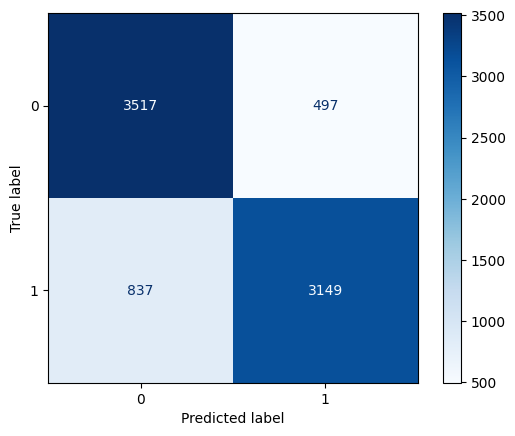

In [12]:
cm = confusion_matrix(y_test, pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [13]:
xgb_model = xgb.XGBClassifier(random_state = 0)
xgb_model.fit(x_train_vect, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=0, ...)

In [14]:
pred_xgb = xgb_model.predict(x_test_vect)

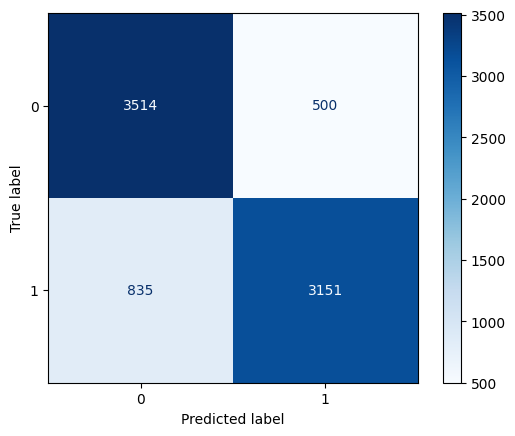

In [15]:
cm = confusion_matrix(y_test, pred_xgb)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [51]:
## Exploring the model

In [52]:
w2v_model.wv.most_similar(positive="warning")
w2v_model.wv.most_similar(positive="warns")
w2v_model.wv.most_similar(positive=["car", "vehicle"], topn=5)

[('arrested', 0.9988049864768982),
 ('during', 0.9987202286720276),
 ('missing', 0.9987146854400635),
 ('plane', 0.9987059831619263),
 ('bomb', 0.9987000823020935)]

# 1. Building article embeddings based on averaging word2vec embeddings 
## - A. based on already pretrained word2vec

In [53]:
import gensim.downloader as api
# Loading already pre-trained model on google news
wv = api.load('word2vec-google-news-300')

In [17]:
x_train_vect_pretrained = np.array([create_text_vectors_from_word_embedding_word2vec_model(wv, sentence, 300) for sentence in x_train])
x_test_vect_pretrained= np.array([create_text_vectors_from_word_embedding_word2vec_model(wv, sentence, 300) for sentence in x_test])

In [18]:
RF = RandomForestClassifier(random_state = 0)
RF.fit(x_train_vect_pretrained, y_train)

RandomForestClassifier(random_state=0)

In [19]:
pred_rf = RF.predict(x_test_vect_pretrained)
RF.score(x_test_vect_pretrained, y_test)

In [21]:
print(classification_report(y_test, pred_rf))

              precision    recall  f1-score   support

           0       0.80      0.87      0.83      4014
           1       0.86      0.78      0.82      3986

    accuracy                           0.83      8000
   macro avg       0.83      0.83      0.83      8000
weighted avg       0.83      0.83      0.83      8000



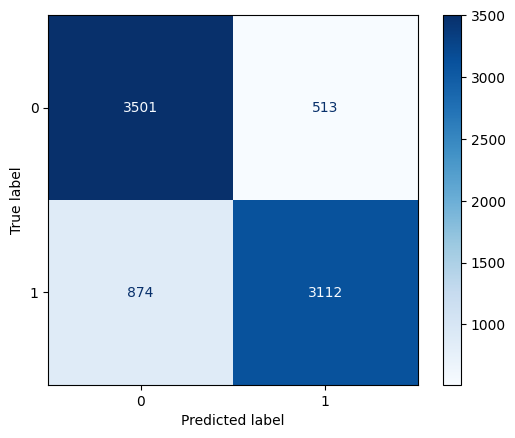

In [22]:
cm = confusion_matrix(y_test, pred_rf)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [23]:
# The question that appears in my head is that Word2vec is already pretrained, so why we should train it once again?
# The answer is that you can use pre-trained model without fitting it to your data if it is general domain
# Link:
# https://datascience.stackexchange.com/questions/110006/why-we-need-to-train-word2vec-when-word2vec-itself-is-said-to-be-pretrained
# https://datascience.stackexchange.com/questions/92856/the-reason-behind-using-a-pre-trained-model
# https://www.google.com/search?q=usng+pretrained+word2vec+or+not&oq=usng+pretrained+word2vec+or+not&gs_lcrp=EgZjaHJvbWUyBggAEEUYOTIJCAEQIRgKGKABMgkIAhAhGAoYoAHSAQgzOTY5ajBqNKgCALACAQ&sourceid=chrome&ie=UTF-8

In [24]:
#Find out what articles were wrongly classified

In [25]:
x_test

32823        Billboard's Top 10 Most Popular Holiday Songs
16298                Watch Live: State Department Briefing
28505    Restaurant prints pro-immigrant note at the bo...
6689       Same-Sex Marriage Laws Pose Protection Quandary
26893    'Star Wars: The Last Jedi' trailer: What does ...
                               ...                        
13618                        U2 fan ordered to destroy CDs
35165    People Got Tested To See What Their Actual Eth...
16359                     Nicolaus Copernicus buried again
3842     The week in finance: US banks jump on deregula...
37682    23 Reasons Why The Great British Bake Off Is T...
Name: title, Length: 8000, dtype: object

In [26]:
results_test_df = pd.DataFrame(x_test)
results_test_df["y_true"] = y_test
results_test_df["y_pred"] = pred_rf

In [27]:
results_test_df

,title,y_true,y_pred
32823,Billboard's Top 10 Most Popular Holiday Songs,1,0
16298,Watch Live: State Department Briefing,0,0
28505,Restaurant prints pro-immigrant note at the bo...,1,0
6689,Same-Sex Marriage Laws Pose Protection Quandary,0,0
26893,'Star Wars: The Last Jedi' trailer: What does ...,1,1
...,...,...,...
13618,U2 fan ordered to destroy CDs,0,0
35165,People Got Tested To See What Their Actual Eth...,1,1
16359,Nicolaus Copernicus buried again,0,0
3842,The week in finance: US banks jump on deregula...,0,0


In [28]:
wrongly_classified = results_test_df[results_test_df["y_true"] != results_test_df["y_pred"]]

In [29]:
wrongly_classified

,title,y_true,y_pred
32823,Billboard's Top 10 Most Popular Holiday Songs,1,0
28505,Restaurant prints pro-immigrant note at the bo...,1,0
5128,"The Playlist: 18 Holiday Songs, 1 Surprise Mix...",0,1
35041,Former Clinton Campaign Adviser: Trump Is a ‘D...,1,0
19463,"YG And Lil Wayne Keep It ""Trill"" On New Song",0,1
...,...,...,...
27435,Scientists find link between cat ownership and...,1,0
12503,Irfan Pathan Gives Fitting Reply After Being A...,0,1
33777,5 things to watch for in a new travel ban,1,0
14454,Billy Ray Cyrus Is Hinting That Miley And Liam...,0,1


In [30]:
i=0
for index, row in wrongly_classified.iterrows():
    print(row["title"])
    print("True Label:", row['y_true'])
    print("Predicted Label:", row['y_pred'])
    print("-" * 40)
    i+=1
    if i == 20:
        break

Billboard's Top 10 Most Popular Holiday Songs
True Label: 1
Predicted Label: 0
----------------------------------------
Restaurant prints pro-immigrant note at the bottom of every receipt
True Label: 1
Predicted Label: 0
----------------------------------------
The Playlist: 18 Holiday Songs, 1 Surprise Mixtape and a Dark New Nine Inch Nails EP 
True Label: 0
Predicted Label: 1
----------------------------------------
Former Clinton Campaign Adviser: Trump Is a ‘Dystopian Super Villain’
True Label: 1
Predicted Label: 0
----------------------------------------
YG And Lil Wayne Keep It "Trill" On New Song
True Label: 0
Predicted Label: 1
----------------------------------------
What might a post-Brexit EU look like?
True Label: 1
Predicted Label: 0
----------------------------------------
Australian Media Crosses The Line As It Compares Virat Kohli To Animals In An Extremely Racist Post!
True Label: 0
Predicted Label: 1
----------------------------------------
Whistle-Blower: ‘Global War

In [54]:
### Exploring the model

In [ ]:
ans_vect =  wv['woman'] + wv['Europe'] + wv['physics'] + wv['scientist'] - wv['male'] - 2 * wv['man']
wv.similar_by_vector(ans_vect, topn= 15)
wv.most_similar(positive= ["Cristiano_Ronaldo", "science"],negative=["sport"], topn=5)
wv.most_similar(positive = ["woman", "sword"], negative = ["man"])
wv.most_similar(positive= ["king", "woman"],negative=["man"], topn=2)
wv.similar_by_vector(wv["king"] + wv["woman"] - wv["man"], topn=2)

# 2. Building article embeddings based on the combination of word2vec and tfidf 

In [31]:
# Source:
# https://freedium.cfd/https://medium.com/@chandu.bathula16/machine-learning-concept-9-71b6bd2ea77d
# https://medium.com/analytics-vidhya/featurization-of-text-data-bow-tf-idf-avgw2v-tfidf-weighted-w2v-7a6c62e8b097

In [32]:
def compute_weighted_word2vec_tf_idf(
    documents: pd.core.series.Series, 
    word2vec_model: gensim.models.keyedvectors.KeyedVectors, 
    tfidf_vectorizer: TfidfVectorizer
):
    '''
    Function that combines tf-idf and word2vec. 
    Instead of just taking an average of word-embeddings from glove or word2vec for each word we multiply its tf-idf value with word2vec embedding 
    and then normalize its value
    '''
    # Let us calculate tf-idf scores
    tfidf_matrix = tfidf_vectorizer.transform(documents)
    tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
    tfidf_scores = tfidf_matrix.toarray()
    
    document_vectors = []

    for i, document in enumerate(documents):
        words = document.split() # Split into sentences
        tfidf_vector = tfidf_scores[i]
        
        doc_vector = np.zeros(word2vec_model.vector_size)  # Zero vector
        
        weight_sum = 0  # sum of tf-idf weights for normalization
        
        for word in words:
            if word in word2vec_model and word in tfidf_feature_names:
                word_vector = word2vec_model[word]
                word_index = np.where(tfidf_feature_names == word)[0][0]
                tfidf_weight = tfidf_vector[word_index]
                
                # Add the weighted word vector to the document vector
                doc_vector += word_vector * tfidf_weight
                weight_sum += tfidf_weight
        
        if weight_sum != 0:
            doc_vector /= weight_sum  # Then we apply normalization by sum of weight of tf-idf vectors
        
        document_vectors.append(doc_vector)
    
    return np.array(document_vectors)

# Compute TF-IDF on the training data
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(x_train)

# Transform the training and test data using the weighted Word2Vec algorithm
x_train_vectors = compute_weighted_word2vec_tf_idf(x_train, wv, tfidf_vectorizer)
x_test_vectors = compute_weighted_word2vec_tf_idf(x_test, wv, tfidf_vectorizer)

0.77975
              precision    recall  f1-score   support

           0       0.80      0.75      0.77      4014
           1       0.76      0.81      0.79      3986

    accuracy                           0.78      8000
   macro avg       0.78      0.78      0.78      8000
weighted avg       0.78      0.78      0.78      8000



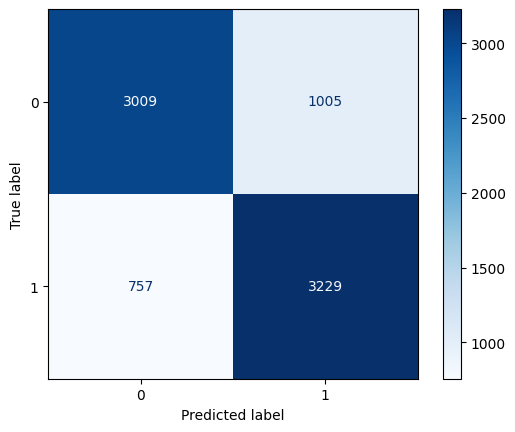

In [34]:
RF = RandomForestClassifier(random_state = 0)
RF.fit(x_train_vectors, y_train)

pred_rf = RF.predict(x_test_vectors)
print(RF.score(x_test_vectors, y_test))
print(classification_report(y_test, pred_rf))

cm = confusion_matrix(y_test, pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# 3. Building article embeddings based on averaging glove embeddings

In [35]:
embeddings_glove = {}
# This is reference to local path
# Glove models are huge, so we decided not to store it in github, but on google drive
path_local = r"C:\Users\Mateusz\Desktop\PRACA INZYNIERSKA\glove.6B.100d.txt"
with open(path_local, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_glove[word] = coefs

In [37]:
def get_glove_text_embedding(
    sentence: str, 
    glove_model: dict,
):
    '''
    Function generating text_embedding from word-embedding glove model. 
    Function similar to the one above for word2vec
    '''
    words = sentence.split()  
    word_vectors_glove = []

    for word in words:
        if word in glove_model: 
            word_vectors_glove.append(glove_model[word])

    if not word_vectors_glove:
        return np.zeros(len(next(iter(glove_model.values()))))
        
    return np.mean(word_vectors_glove, axis=0)

In [39]:
x_train_vect_glove = np.array([get_glove_text_embedding(sentence, embeddings_glove) for sentence in x_train])
x_test_vect_glove = np.array([get_glove_text_embedding(sentence, embeddings_glove) for sentence in x_test])

0.807125
              precision    recall  f1-score   support

           0       0.80      0.83      0.81      4014
           1       0.82      0.79      0.80      3986

    accuracy                           0.81      8000
   macro avg       0.81      0.81      0.81      8000
weighted avg       0.81      0.81      0.81      8000



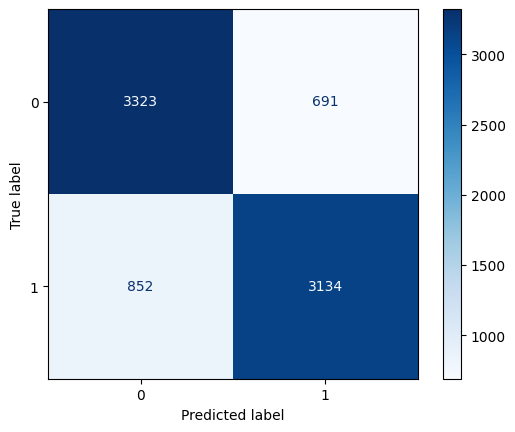

In [40]:
RF = RandomForestClassifier(random_state = 0)
RF.fit(x_train_vect_glove, y_train)

pred_rf = RF.predict(x_test_vect_glove)
print(RF.score(x_test_vect_glove, y_test))
print(classification_report(y_test, pred_rf))

cm = confusion_matrix(y_test, pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()